<a href="https://colab.research.google.com/github/Chizara69/rosee.github.io/blob/main/Asses_Image_Classification_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

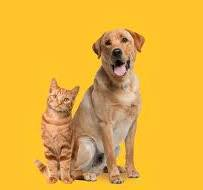

#CAT OR DOG BLOG

#Image recognition is used to identify animal species for different tasks such as surveys and preservation

This blog contains steps to train a machine-learning model to predict whether an image is a cat or a dog.





#Importing  Libraries & modules
*   The first step was to import all the neccessary libraries and modules.



In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# libraries for ML algorithms
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from random import randint
from random import seed

RANDOM_SEED = 100

#Drive & File setup

*   A data folder was provided which included 2 folders (i.training_images, ii.test_images and 2 csv files (i.train.csv, ii. test.csv
Each train_image has an id as its name which is referred to by the “train.csv” file.




In [ ]:
#mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil # Extracts zip file
shutil.unpack_archive('/content/drive/MyDrive/data_asses_image.zip', '/content/Images', 'zip')

In [ ]:
# Path to the unzip file
data_folder = '/content/Images'

#Loading Training & Testing Data with Basic EDA



In [ ]:
# load training data
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))

# Looks at the 1st 5 rows of our data
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


,id,label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


In [ ]:
# number of rows and columns
print(df_train.shape)

(10000, 2)


In [ ]:
#Check for missing values - no missing values therefore no need to use any fill techniques
df_train.isnull().sum()

id       0
label    0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

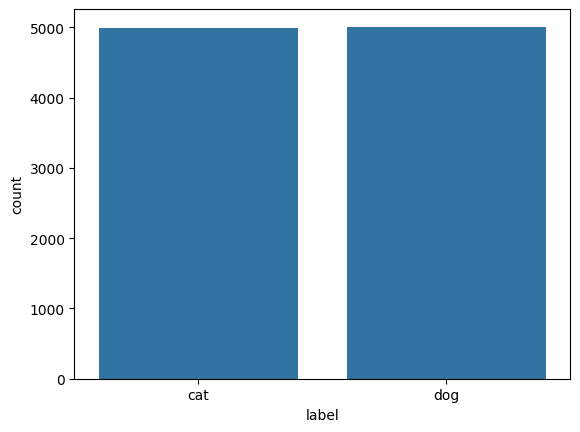

In [ ]:
# Below we can see that the number of cat & dog images are equal hence no imbalaced data issues
sns.countplot(x=df_train['label'])

In [ ]:
# load testing data
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


,id
0,1
1,2
2,3
3,4
4,5


# Loading images to folder

In [ ]:
# method to load images in a folder
def load_images(ids, folder_path, dim=None):
  '''
  ids: list of image ids
  folder_path: path to image folder
  dim: dimensions to resize images (optional)
  '''
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images

# Preparing images
*   Images were re-sized as we will need equal length vectors for the models features.

  

In [ ]:
#converting images to a common dimension
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [00:33<00:00, 301.50it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [00:03<00:00, 314.59it/s]

Number of testing images loaded: 1000


# Taking a look at some sample images
*   A few sample images where displayed just to show some cute images.



Image Id: 2386
Image Id: 7528
Image Id: 7453
Image Id: 2863
Image Id: 6439


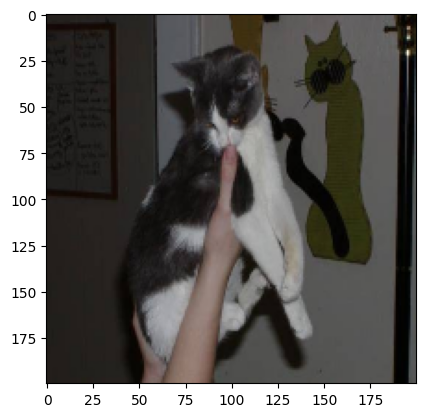

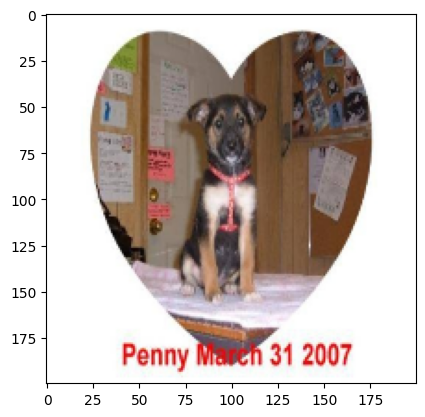

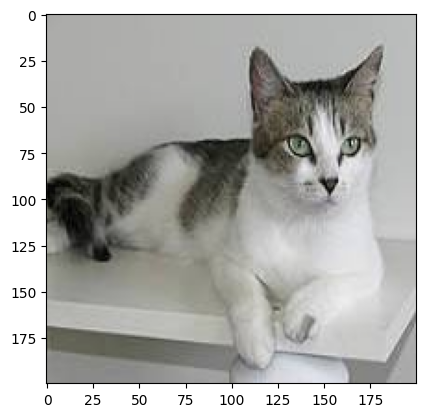

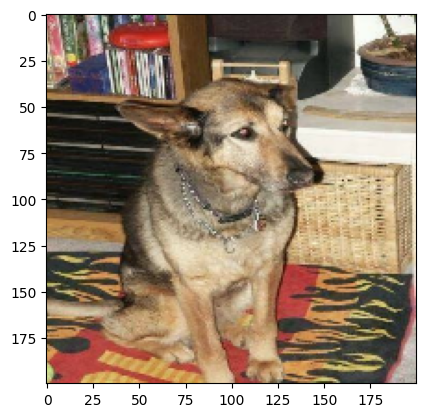

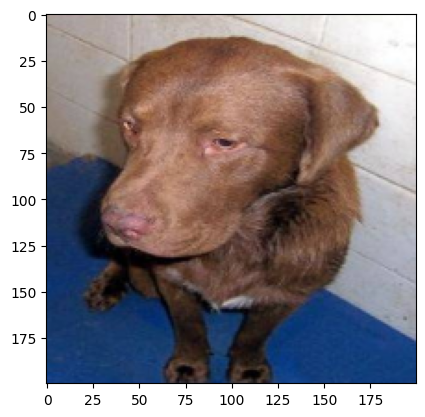

In [ ]:
# picks a random sample of images
seed(RANDOM_SEED)
sample_images = []

for i in range(5):
    value = randint(0, len(train_images)-1)
    print(f'Image Id: {value}')
    sample_images.append(train_images[value])

# Show original color images
for img in sample_images:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title
    plt.show()

#Table 1-Image pre-processing feature extraction & models

 Here are some combinations that we will be experimenting with:-

| Model | Pre-processing | Feature Extraction |
|-----------------|-----------------|-----------------|
| C1| gray scaling| image vectorisation |
| C2| gray scaling| edge vectorisation (canny) |
| C3| gray scaling| HOG  |
| | |







# Finding best model predictions

* XGBoost yielded an accuracy score of 73%
* Observation made on experiments:-
Using SVM, feature extraction generated 40,000 features, an accuracy of 52% and very long processing time. Applying canny edge vectorisation improved accuracy to 56%.
* SVM Classifier was chosen for initial experiments as it's a popular algorithm, effective for binary classification, however struggles with high dimensionality
According to Sklearn https://scikit-learn.org/stable/modules/svm.html. Possible solution: PCA.
* Random forest, a clasifier that can handle high dimensional data, produced a much faster processing time, and the best accuracy of all combinations, 69% applying gray scaling & HOG. This combination was chosen to predict on Xgboost. A powerful ensemble method that can achieve high accuracy.
* See summary model evaluation report:-


| Algorithm | Model | Pre-processing | Feature xtr |  Accuracy |
|-----------------|-----------------|-----------------|-----------------|-----------------|
|SVM | C1 | gray scaling | vectorisation | .516 |
| SVM | C2 | gray scaling | edge detection (canny) | .56 |
| Random Forest | C4 | gray scaling | vectorisation | .607
| Random Forest | C5 | gray scaling | edge detection (canny) | .595
| Random Forest | C6 | gray scaling | HOG vector | .687 |
| XGboost | C7 | gray scaling | HOG vector | .726 |



# Steps for test_data predictions using XGBoost

In [ ]:
# method to calculate evaluation results
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()


In [ ]:
print(df_train['label'].unique())

['cat' 'dog']


In [ ]:
# Converting class categories to binary form
# 0:cat   1:Dog
df_train['label'] = df_train['label'].replace({'cat':0, 'dog':1})

In [ ]:
print(df_train['label'].unique())

[0 1]


In [ ]:
# Function for predictions and evaluation
def get_xgb_predictions(X_train, X_val, y_train, y_val):
    # Build model
    xgb_clf = xgb.XGBClassifier( random_state=RANDOM_SEED)
    xgb_clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = xgb_clf.predict(X_val)

    # Evaluation
    evaluate(y_val, y_pred, xgb_clf.classes_)

    print("Classification Report:")
    print(classification_report(y_val, y_pred))

    return xgb_clf

In [ ]:
# method to get image features
def get_features_c7(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train = get_features_c7(train_images)

print(features_train.shape)

(10000, 3780)


Accuracy: 0.7263333333333334


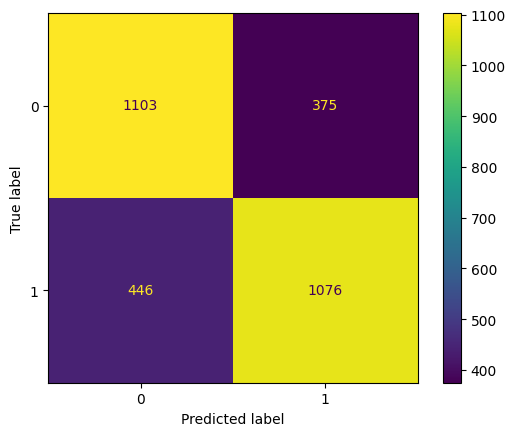

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1478
           1       0.74      0.71      0.72      1522

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000



In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

# train model
c7 = get_xgb_predictions(X_train, X_val, y_train, y_val)


In [ ]:
# feature extraction - test data
features_test = get_features_c7(test_images)
print(features_test.shape)

# get model predictions
predictions = c7.predict(features_test)
print(predictions)

(1000, 3780)
[1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0
 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1
 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1
 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0
 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1
 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0
 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1
 0 0 0 1 1 0

In [ ]:
df_test['prediction'] = predictions

In [ ]:
# Converting numerical classification back to categorical
df_test['prediction'] = df_test['prediction'].replace({0:'cat', 1:'dog'})

In [ ]:
df_test.head()

In [ ]:
data = []
for index, row in df_test.iterrows():
  data.append({'id': row['id'], 'prediction': row['prediction']})

print(data[0:5])

[{'id': 1, 'prediction': 'dog'}, {'id': 2, 'prediction': 'cat'}, {'id': 3, 'prediction': 'cat'}, {'id': 4, 'prediction': 'cat'}, {'id': 5, 'prediction': 'cat'}]


In [ ]:
# Saving file
import json

submission_file_path = 'submission_image.json'
with open(submission_file_path, 'w') as fp:
  for i in data:
    fp.write(json.dumps(i) + '\n')

#Conclusion
The classification report indicates that the XGBoost model is performing with precision from 71% to 74%, however there is room for improvement.
Future experiments would include spending more time to apply model tuning to optimise performance. Exploring GridsearchCV for optimising peformance is a must.
Take aways:
It's a case of trial and experiment to find your best performing model.